In [4]:
import os
import math

import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
from dask.dataframe.dispatch import tolist

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans


PATH_TO_DATASET = 'MLPC2025_dataset'

assert os.path.exists(PATH_TO_DATASET), "The dataset folder 'MLPC2025_dataset' does not exist; download the data set and extract its content."
assert os.path.exists(os.path.join(PATH_TO_DATASET, 'annotations.csv')), "The file 'MLPC2025_dataset/annotations.csv' does not exist."
assert os.path.exists(os.path.join(PATH_TO_DATASET, 'metadata.csv')), "The file 'MLPC2025_dataset/metadata.csv' does not exist."
assert os.path.exists(os.path.join(PATH_TO_DATASET, 'audio_features')), "The folder 'MLPC2025_dataset/audio_featues' does not exist."

In [5]:
# load the metadata
metadata_df = pd.read_csv(os.path.join(PATH_TO_DATASET, "metadata.csv"))
title_embeddings = np.load(os.path.join(PATH_TO_DATASET, "metadata_title_embeddings.npz"))["embeddings"]
keywords_embeddings = np.load(os.path.join(PATH_TO_DATASET, "metadata_keywords_embeddings.npz"))["embeddings"]

# load the annotations
annotations_df = pd.read_csv(os.path.join(PATH_TO_DATASET, "annotations.csv"))
annotations_embeddings = np.load(os.path.join(PATH_TO_DATASET, "annotations_text_embeddings.npz"))["embeddings"]

# load audio features
feature_filename = metadata_df.loc[0, "filename"].replace("mp3", "npz")
features = np.load(os.path.join(PATH_TO_DATASET, "audio_features", feature_filename))
print(list(features.keys()))

print("Shape of title embedding (time, n_features)", features["embeddings"].shape)
print("Shape of ZCR feature (time, n_features)", features["zerocrossingrate"].shape)
print("Shape of mel-scaled energies (time, n_features)", features["melspectrogram"].shape)
print("Shape of MFCC features (time, n_features)", features["mfcc"].shape)
print("Shape of MFCC-delta features (time, n_features)", features["mfcc_delta"].shape)
print("Shape of MFCC-delta-delta features (time, n_features)", features["mfcc_delta2"].shape)
print("Shape of flatness (time, n_features)", features["flatness"].shape)
print("Shape of centroid (time, n_features)", features["centroid"].shape)
print("Shape of flux (time, n_features)", features["flux"].shape)
print("Shape of energy (time, n_features)", features["energy"].shape)
print("Shape of power (time, n_features)", features["power"].shape)
print("Shape of bandwidth (time, n_features)", features["bandwidth"].shape)
print("Shape of contrast (time, n_features)", features["contrast"].shape)

['embeddings', 'melspectrogram', 'mfcc', 'mfcc_delta', 'mfcc_delta2', 'flatness', 'centroid', 'flux', 'energy', 'power', 'bandwidth', 'contrast', 'zerocrossingrate']
Shape of title embedding (time, n_features) (233, 768)
Shape of ZCR feature (time, n_features) (233, 1)
Shape of mel-scaled energies (time, n_features) (233, 64)
Shape of MFCC features (time, n_features) (233, 32)
Shape of MFCC-delta features (time, n_features) (233, 32)
Shape of MFCC-delta-delta features (time, n_features) (233, 32)
Shape of flatness (time, n_features) (233, 1)
Shape of centroid (time, n_features) (233, 1)
Shape of flux (time, n_features) (233, 1)
Shape of energy (time, n_features) (233, 1)
Shape of power (time, n_features) (233, 1)
Shape of bandwidth (time, n_features) (233, 1)
Shape of contrast (time, n_features) (233, 7)


# a)

In [6]:
# Combine all audio features into a single array (across the time steps)
def flatten_features(features_dict):
    feature_list = []
    feature_names = []
    for key, values in features_dict.items():
        feature_list.append(values.reshape(-1, values.shape[-1]))  # flatten over time dimension
        feature_names.extend([f"{key}_{i}" for i in range(values.shape[-1])])  # name features
    combined_features = np.hstack(feature_list)
    return combined_features, feature_names




In [7]:
# Flatten audio features and collect their names
audio_features, feature_names = flatten_features(features)
print("Shape of combined audio features (time, n_features)", audio_features.shape)



# Normalize the data (StandardScaler standardizes each feature to have zero mean and unit variance)
scaler = StandardScaler()
normalized_features = scaler.fit_transform(audio_features)

# Apply PCA for dimensionality reduction
pca = PCA()
pca_result = pca.fit_transform(normalized_features)

Shape of combined audio features (time, n_features) (233, 942)


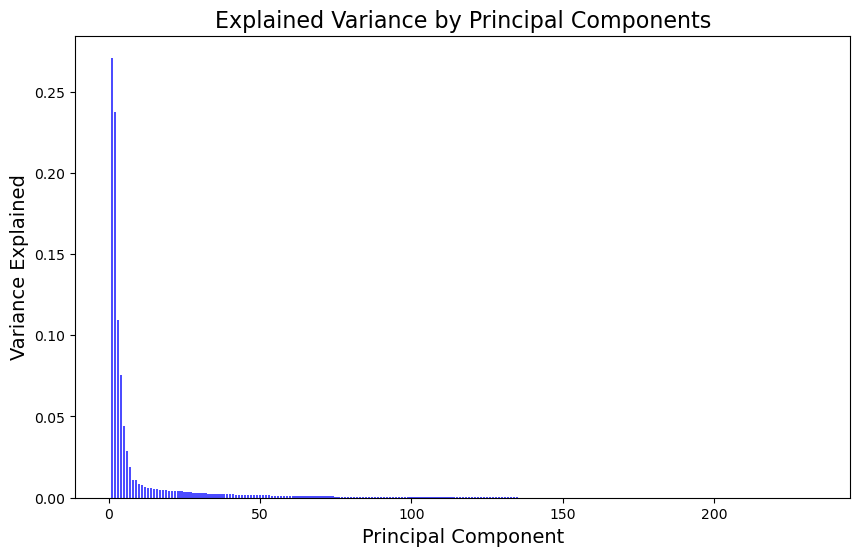

In [8]:
# Visualizing variance explained by each principal component
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, alpha=0.7, color="blue")
plt.xlabel("Principal Component", fontsize=14)
plt.ylabel("Variance Explained", fontsize=14)
plt.title("Explained Variance by Principal Components", fontsize=16)
plt.show()

Number of components needed to reach 95.0% explained variance: 52


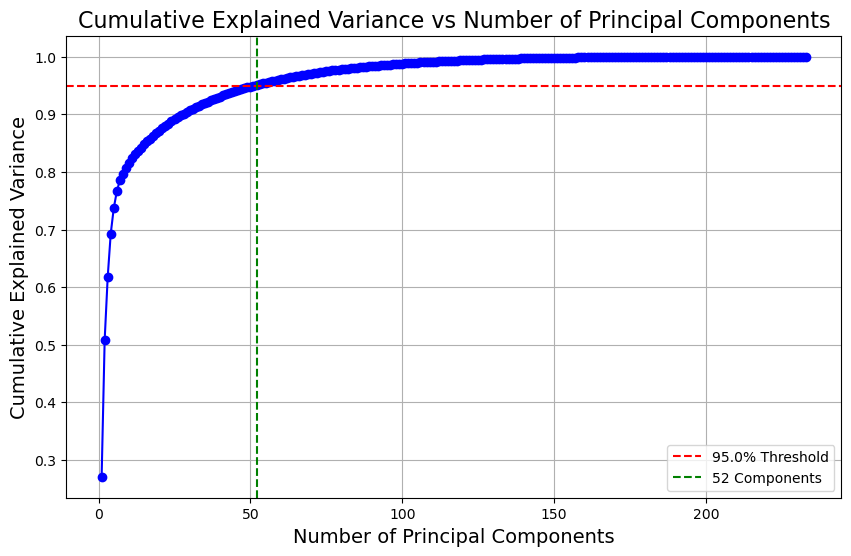

In [9]:
# Target explained variance threshold
explained_variance_threshold = 0.95  # Example: 95%
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)  # Cumulative sum of explained variance
n_components = np.argmax(cumulative_variance >= explained_variance_threshold) + 1  # Find number of components

print(
    f"Number of components needed to reach {explained_variance_threshold * 100:.1f}% explained variance: {n_components}")

# Perform PCA again with the reduced number of components
pca_reduced = PCA(n_components=n_components)
pca_result_reduced = pca_reduced.fit_transform(normalized_features)

# %%
# Plot cumulative explained variance for visualization
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', color='blue')
plt.axhline(y=explained_variance_threshold, color='red', linestyle='--',
            label=f"{explained_variance_threshold * 100:.1f}% Threshold")
plt.axvline(x=n_components, color='green', linestyle='--', label=f"{n_components} Components")
plt.xlabel("Number of Principal Components", fontsize=14)
plt.ylabel("Cumulative Explained Variance", fontsize=14)
plt.title("Cumulative Explained Variance vs Number of Principal Components", fontsize=16)
plt.legend()
plt.grid()
plt.show()


In [10]:
# %%
# Create a mapping from feature names to feature groups (e.g., melspectrogram, mfcc, etc.)
def extract_feature_group(feature_name):
    return feature_name.split("_")[0]  # Extract the group name before the first underscore


# Group and count contributions in each principal component
top_n_components = n_components  # Number of components to analyze
n_top_features = 10  # Number of top features per component

feature_group_importance = {}

for i, component in enumerate(pca.components_[:top_n_components]):
    top_features_idx = np.argsort(np.abs(component))[-n_top_features:]  # Indices of the top features
    for idx in top_features_idx:
        feature_group = extract_feature_group(feature_names[idx])
        feature_group_importance[feature_group] = feature_group_importance.get(feature_group, 0) + 1

# Sort and display the feature group importance
sorted_importance = sorted(feature_group_importance.items(), key=lambda x: x[1], reverse=True)

print(f"Top contributing feature groups across the first {top_n_components} components:")
for group, count in sorted_importance:
    print(f"Feature Group: {group}, Count: {count}")


Top contributing feature groups across the first 52 components:
Feature Group: mfcc, Count: 338
Feature Group: melspectrogram, Count: 82
Feature Group: embeddings, Count: 76
Feature Group: contrast, Count: 14
Feature Group: centroid, Count: 3
Feature Group: energy, Count: 2
Feature Group: power, Count: 1
Feature Group: flatness, Count: 1
Feature Group: bandwidth, Count: 1
Feature Group: zerocrossingrate, Count: 1
Feature Group: flux, Count: 1


# b)

In [11]:
def flatten_important_features(features_dict):
    important_features = ["mfcc", "melspectrogram", "embeddings", "contrast", "centroid", "energy", "power", "flatness", "bandwidth", "zerocrossingrate","flux"]
    feature_list = []
    feature_names = []
    for key, values in features_dict.items():
        if key in important_features:
            feature_list.append(values.reshape(-1, values.shape[-1]))  # flatten over time dimension
            feature_names.extend([f"{key}_{i}" for i in range(values.shape[-1])])  # name features
    combined_features = np.hstack(feature_list)
    return combined_features, feature_names



In [12]:

metadata_df.set_index("filename", inplace=True)

audio_features = {}


for idx, row in metadata_df.iterrows():

    feature_filename = idx.replace("mp3", "npz")
    features = np.load(os.path.join(PATH_TO_DATASET, "audio_features", feature_filename))
    features_flattened, feature_names = flatten_important_features(features)
    audio_features[idx] = features_flattened
print("Number of feature files:", len(audio_features))
print("Shape of features: ", features_flattened.shape)

# load audio features
#feature_filename = metadata_df.loc[0, "filename"].replace("mp3", "npz")
#features = np.load(os.path.join(PATH_TO_DATASET, "audio_features", feature_filename))



Number of feature files: 9026
Shape of features:  (222, 878)


In [13]:
concatenated_feature_tensor = np.concatenate(list(audio_features.values()), axis=0)
print("Shape of all feature tensors concatenated:", concatenated_feature_tensor.shape)
scaler = StandardScaler().fit(concatenated_feature_tensor)

Shape of all feature tensors concatenated: (1684753, 878)


In [14]:

def get_features_of_annotation(
    onset: float,
    offset: float,
    audio_features: np.ndarray,
    scaler: StandardScaler = None
) -> np.ndarray:

    RESOLUTION = 0.12 # temporal resolution of the features is 120 ms
    start_idx = math.floor(onset / RESOLUTION)
    offset_idx = math.ceil(offset / RESOLUTION)

    audio_features = audio_features[start_idx:offset_idx, :]
    if scaler is not None:
        audio_features = scaler.transform(audio_features)
    return audio_features.mean(axis=0)

In [15]:
def get_unannotated_features(
    annotations_df: pd.DataFrame,
    audio_features: dict,
    scaler: StandardScaler = None,
    resolution: float = 0.12
):
    unannotated_features = []
    filenames = annotations_df["filename"].unique()
    for filename in filenames:
        features = audio_features[filename]
        max_time = features.shape[0] * resolution  # Total duration based on resolution
        annotated_intervals = annotations_df[annotations_df["filename"] == filename]
        annotated_intervals = annotated_intervals.sort_values(by="onset")

        intervals = []
        ignore_list = []

        for i, row in annotated_intervals.iterrows():
            if i not in ignore_list:
                current_onset = row["onset"]
                current_offset = row["offset"]

                for j, row_ in annotated_intervals.iterrows():
                    if current_offset > row_["onset"] and current_onset is not row_["onset"]:
                        ignore_list.append(j)
                        if current_offset < row_["offset"]:
                            current_offset = row_["offset"]

                intervals.append((current_onset, current_offset))



        unannotated_intervals = []
        current_time = 0.0

        for onset, offset in intervals:
            if current_time < onset:
                unannotated_intervals.append((current_time, onset))
            current_time = max(current_time, offset)
        if current_time < max_time:
            unannotated_intervals.append((current_time, max_time))


        # Create unannotated intervals

        '''for _, row in annotated_intervals.iterrows():
            if current_time < row["onset"]:
                unannotated_intervals.append((current_time, row["onset"]))
            current_time = max(current_time, row["offset"])
        if current_time < max_time:  # Remaining unannotated end interval
            unannotated_intervals.append((current_time, max_time))'''


        # Iterate over unannotated intervals, extract features
        for onset, offset in unannotated_intervals:
            start_idx = math.floor(onset / resolution)
            offset_idx = math.ceil(offset / resolution)
            segment_features = features[start_idx:offset_idx, :]
            if scaler is not None:
                segment_features = scaler.transform(segment_features)
            unannotated_features.append(segment_features.mean(axis=0))  # Aggregate mean
    return np.array(unannotated_features)



In [16]:
X = np.zeros((len(annotations_df), features_flattened.shape[1]))
for i, row in annotations_df.iterrows():
    X[i] = get_features_of_annotation(row['onset'], row['offset'], audio_features[row['filename']], scaler)

print("Audio Features of annotated regions:", X.shape)

Audio Features of annotated regions: (35826, 878)


In [17]:
# Example usage
unannotated_X = get_unannotated_features(annotations_df, audio_features, scaler)
print("Audio Features of unannotated regions:", unannotated_X.shape)

Audio Features of unannotated regions: (21392, 878)


In [18]:
# Combine both datasets and create labels
combined_data = np.vstack((X, unannotated_X))

# Initialize and apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=100, n_jobs=-1)
combined_tsne = tsne.fit_transform(combined_data)

combined_tsne.shape

(57218, 2)

In [19]:
#X_tsne = tsne.fit_transform(X)
#X_tsne.shape

In [20]:
#unannotated_X_tsne = tsne.fit_transform(unannotated_X)
#unannotated_X_tsne.shape

# c)

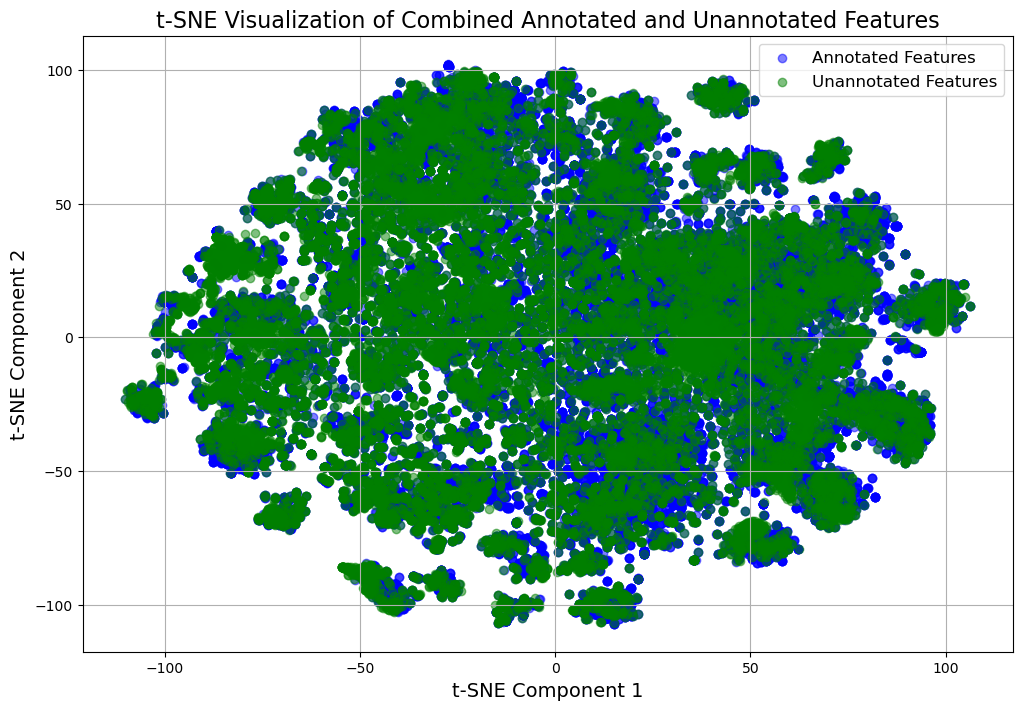

In [21]:
# Create a scatter plot
plt.figure(figsize=(12, 8))

# Plot the annotated features
plt.scatter(combined_tsne[:len(X), 0], combined_tsne[:len(X), 1],
            c='blue', label='Annotated Features', alpha=0.5)

# Plot the unannotated features
plt.scatter(combined_tsne[len(X):, 0], combined_tsne[len(X):, 1],
            c='green', label='Unannotated Features', alpha=0.5)

# Add plot details
plt.title('t-SNE Visualization of Combined Annotated and Unannotated Features', fontsize=16)
plt.xlabel('t-SNE Component 1', fontsize=14)
plt.ylabel('t-SNE Component 2', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

# Show the plot


In [22]:
'''# Number of clusters
k = 25  # Decide the number of clusters based on your task or analysis

# Apply K-Means clustering on the 2-dimensional t-SNE data
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans_labels = kmeans.fit_predict(X_tsne)

# Create a scatter plot with clusters
plt.figure(figsize=(12, 8))
for cluster in range(k):
    plt.scatter(X_tsne[kmeans_labels == cluster, 0], X_tsne[kmeans_labels == cluster, 1], label=f'Cluster {cluster}')
# Add cluster centroids to the plot
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200, label='Centroids')

# Add plot details
plt.title(f'K-Means Clustering of t-SNE Features (k={k})', fontsize=16)
plt.xlabel('t-SNE Component 1', fontsize=14)
plt.ylabel('t-SNE Component 2', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()'''

"# Number of clusters\nk = 25  # Decide the number of clusters based on your task or analysis\n\n# Apply K-Means clustering on the 2-dimensional t-SNE data\nkmeans = KMeans(n_clusters=k, random_state=42)\nkmeans_labels = kmeans.fit_predict(X_tsne)\n\n# Create a scatter plot with clusters\nplt.figure(figsize=(12, 8))\nfor cluster in range(k):\n    plt.scatter(X_tsne[kmeans_labels == cluster, 0], X_tsne[kmeans_labels == cluster, 1], label=f'Cluster {cluster}')\n# Add cluster centroids to the plot\ncentroids = kmeans.cluster_centers_\nplt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200, label='Centroids')\n\n# Add plot details\nplt.title(f'K-Means Clustering of t-SNE Features (k={k})', fontsize=16)\nplt.xlabel('t-SNE Component 1', fontsize=14)\nplt.ylabel('t-SNE Component 2', fontsize=14)\nplt.legend(fontsize=12)\nplt.grid(True)\nplt.show()"

In [23]:
vectors = {"vectors": combined_data.tolist()}
features_df = pd.DataFrame(vectors)

kmeans = KMeans(n_clusters=25, max_iter=3000, random_state=1).fit(combined_tsne)
clusters_assignment = kmeans.predict(combined_tsne)
features_df['cluster_assignment'] = clusters_assignment
features_df['cluster_assignment'].head(5)

0     5
1    24
2     7
3     8
4     3
Name: cluster_assignment, dtype: int32

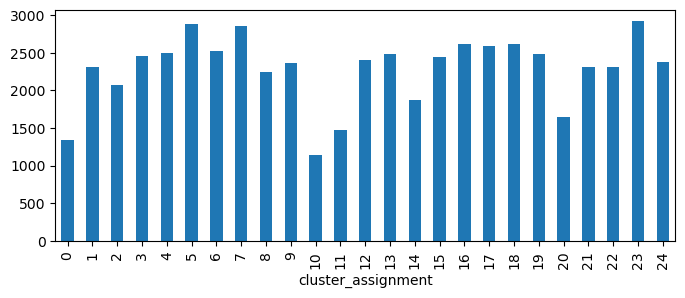

In [24]:
counts = features_df["cluster_assignment"].value_counts(sort=False).sort_index()
counts.plot(kind="bar", figsize=(8, 3))
plt.show()

In [25]:


# Create the unannotated column as a copy of the cluster_assignment column
features_df['unannotated'] = features_df['cluster_assignment']

# Set the first len(X) entries in the unannotated column to False
features_df.loc[:len(X), 'unannotated'] = "Annotated"
features_df.loc[len(X):, 'unannotated'] = "Unannotated"

# Display the first 5 rows of the dataframe to verify
features_df[['cluster_assignment', 'unannotated']].head(5)


C:\Users\leosp\AppData\Local\Temp\ipykernel_20984\3008474993.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Annotated' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  features_df.loc[:len(X), 'unannotated'] = "Annotated"


,cluster_assignment,unannotated
0,5,Annotated
1,24,Annotated
2,7,Annotated
3,8,Annotated
4,3,Annotated


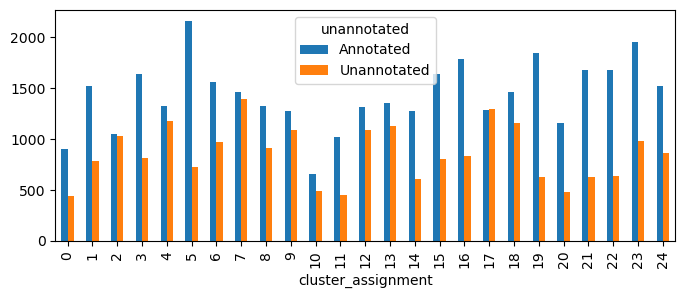

In [26]:
counts = features_df[["cluster_assignment", "unannotated"]].groupby(["cluster_assignment", "unannotated"]).size().unstack()

counts.plot(kind="bar", figsize=(8, 3))
plt.show()

In [30]:
vectors_annotated = {"vectors": combined_data[:len(X)].tolist()}
features_annotated_df = pd.DataFrame(vectors_annotated)

kmeans = KMeans(n_clusters=24, max_iter=3000, random_state=1).fit(combined_tsne[:len(X)])
clusters_assignment_annotated = kmeans.predict(combined_tsne[:len(X)])

features_annotated_df['clusters_assignment_annotated'] = clusters_assignment_annotated
features_annotated_df['clusters_assignment_annotated'].head(5)

0    12
1    16
2    18
3     2
4    22
Name: clusters_assignment_annotated, dtype: int32

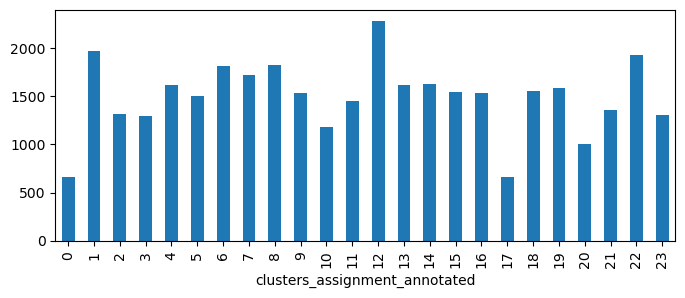

In [31]:
counts = features_annotated_df["clusters_assignment_annotated"].value_counts(sort=False).sort_index()
counts.plot(kind="bar", figsize=(8, 3))
plt.show()

In [33]:
# Save the variable to a file (e.g., .npy format)
np.save('audio_features_clusters_assignment', features_annotated_df['clusters_assignment_annotated'])
